# Evaluate the effects of graph pruning on boundary preservation (Fig S2)

In [1]:
import itertools
import torch
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from plotnine import *

import smoother
from smoother import SpatialLoss, SpatialWeightMatrix
from smoother.utils import *

import scanpy as sc
import squidpy as sq
import anndata

In [2]:
fig_res_dir = "/Users/jysumac/Projects/Smoother_paper/results/figures/loss_design/"
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/breast_cancer_visium/"

## Load and preprocess the breast cancer spatial data

In [3]:
from matplotlib.image import imread
import json

def read_sp_data(data_dir, sample_id):
    count_dir = data_dir + \
        f"/filtered_count_matrices/{sample_id}_filtered_count_matrix/"
    sp_dir = data_dir + f"/spatial/{sample_id}_spatial/"
    meta_dir = data_dir + f"/metadata/{sample_id}_metadata.csv"
    
    # load counts
    adata = sc.read_10x_mtx(count_dir)
    
    # load spatial data
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][sample_id] = dict()

    files = dict(
        tissue_positions_file = sp_dir + '/tissue_positions_list.csv',
        scalefactors_json_file = sp_dir + '/scalefactors_json.json',
        hires_image = sp_dir + '/tissue_hires_image.png',
        lowres_image = sp_dir  + '/tissue_lowres_image.png',
    )

    adata.uns["spatial"][sample_id]['images'] = dict()

    for res in ['hires', 'lowres']:
        try:
            adata.uns["spatial"][sample_id]['images'][res] = imread(
                str(files[f'{res}_image'])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    with open(files['scalefactors_json_file']) as f:
        js = json.load(f)
    adata.uns["spatial"][sample_id]['scalefactors'] = js

    # read coordinates
    positions = pd.read_csv(files['tissue_positions_file'], header=None)
    positions.columns = [
        'barcode',
        'in_tissue',
        'array_row',
        'array_col',
        'pxl_col_in_fullres',
        'pxl_row_in_fullres',
    ]
    positions.index = positions['barcode']

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
    adata.obs.drop(
        columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
        inplace=True,
    )
    
    # load meta
    meta = pd.read_csv(meta_dir, header=0, sep=',', index_col=0)
    adata.obs = adata.obs.join(meta, how="left")
    
    return adata

### Load data and QC

In [4]:
#sample_id = "CID44971"
sample_id = "1160920F"
adata = read_sp_data(data_dir, sample_id)

# QC
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

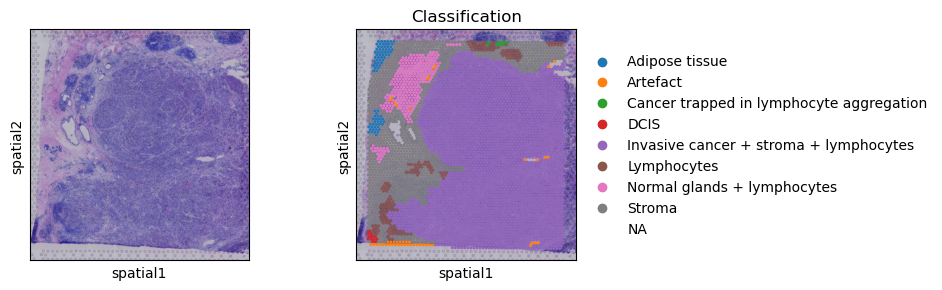

In [5]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(adata, color=[None, 'Classification'], size=1.5)

### UMAP and transcriptomic clustering

In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=6, n_pcs=20)
sc.tl.leiden(adata, resolution=0.15, key_added='exp_clu_leiden')
sc.tl.umap(adata)

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:108

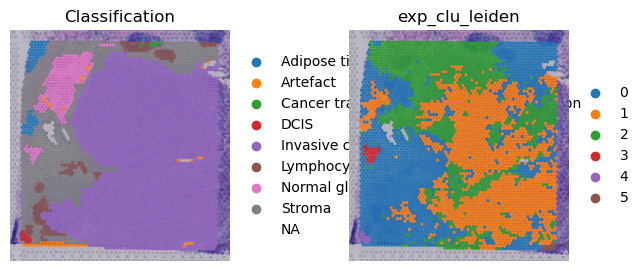

In [7]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(adata, color = ['Classification', 'exp_clu_leiden'], size=1.5, frameon=False)

### Find boundary pairs

In [8]:
# spatial coordinates
pixels = adata.obsm['spatial']

# calculate weight matrix
w_raw = SpatialWeightMatrix()
w_raw.calc_weights_knn(pixels, k = 6, symmetric = True, row_scale = False)

# define boundary pairs and interior pairs using annotation
neighbors = w_raw.swm.indices()
spot_ids = adata.obs['Classification'].to_numpy()
is_in_same_group = torch.tensor(spot_ids[neighbors[0]] == spot_ids[neighbors[1]])
is_boundary = torch.sparse_coo_tensor(
    neighbors, ~is_in_same_group, w_raw.swm.shape
).coalesce()
is_interior = torch.sparse_coo_tensor(
    neighbors, is_in_same_group, w_raw.swm.shape
).coalesce()

print(f"Boundary pairs: {(~is_in_same_group).sum()}. Interior pairs: {is_in_same_group.sum()}." )

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Boundary pairs: 2180. Interior pairs: 26622.


#### Visualize boundary

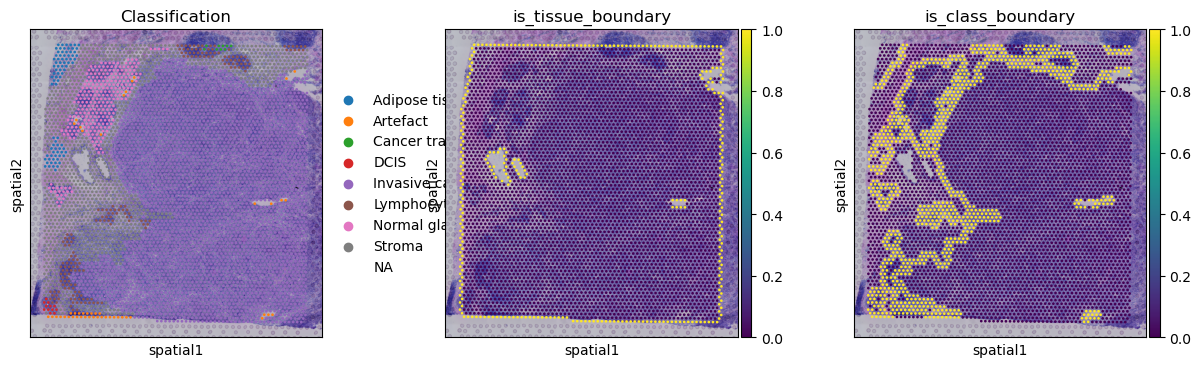

In [9]:
adata.obs['is_tissue_boundary'] = (torch.sparse.sum(w_raw.swm, 1).to_dense() < 6) * 1
adata.obs['is_class_boundary'] = (torch.sparse.sum(is_boundary, 1).to_dense() > 0) * 1

with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.spatial(adata, color = ['Classification', 'is_tissue_boundary', 'is_class_boundary'], size=1)

### Histology clustering

#### Extract histology features

In [10]:
import warnings
import squidpy as sq

adata2 = adata.copy()
adata2.obsm['spatial'] = \
    (adata2.obsm['spatial'] * \
     adata2.uns["spatial"][sample_id]['scalefactors']['tissue_hires_scalef']
    ).astype(int)

img = sq.im.ImageContainer(adata2.uns["spatial"][sample_id]['images']['hires'])

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sq.im.calculate_image_features(
        adata2,
        img.compute(),
        features=["summary", "texture"], 
        key_added="hist_features",
        n_jobs=4,
        mask_circle = True,
        scale = 1.0,
        spot_scale = 1
    )

adata2.obsm['spatial'] = adata.obsm['spatial']

  0%|          | 0/4895 [00:00<?, ?/s]

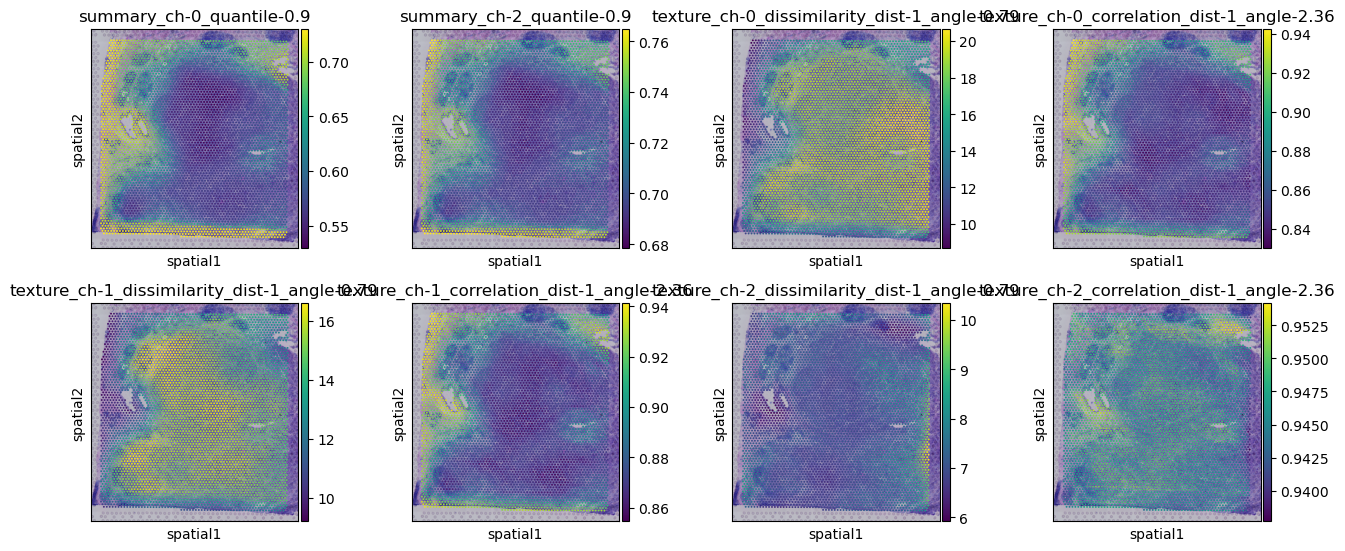

In [11]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(
        sq.pl.extract(adata2, "hist_features"),
        color = adata2.obsm['hist_features'].columns[np.arange(0, 75, 10)]
    )

#### Cluster using histology features

In [12]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, regex = '^(summary)|(texture)', res = 0.1) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if regex is not None:
        features.filter(regex = regex)
    
    # create temporary adata to calculate the clustering
    adata = anndata.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution=res)

    return adata.obs["leiden"]

In [13]:
# calculate feature clusters
adata2.obs["hist_clu_leiden"] = cluster_features(adata2.obsm["hist_features"], res = 0.15)

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/utils.py:252: UserWarning: X converted to numpy array with dtype float64


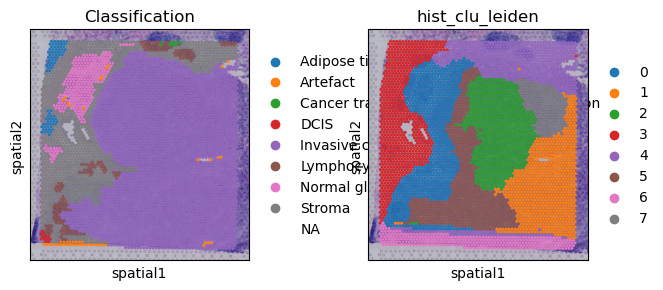

In [14]:
# compare feature and gene clusters
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(adata2, color=["Classification", "hist_clu_leiden"], size = 1.5)

### Calculate pairwise similarity

#### Transcriptomic

In [15]:
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)

# calculate transcriptomic similarity
sim_expr = calc_feature_similarity_sparse(
    yy, neighbors, nonneg = True,
    dist_metric='cosine', reduce = 'pca', dim = 10, return_type='sparse'
)

#### Histological

In [16]:
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']

# spatial coordinates
pixels = adata.obsm['spatial']

# calculate histology similarity
sim_hist = calc_histology_similarity_sparse(
    pixels, w_raw.swm.indices(),
    img, scale_factors=sf, 
    dist_metric='euclidean',
    reduce = 'pca',
    dim = 10
)

#### Check distribution

In [17]:
def get_hist_sim(sim, is_in_same_group):
    # calculate pdf
    NUM_BIN = 100
    hist_x = np.arange(NUM_BIN)/100
    hist_s_b = torch.histc(
        sim.values()[~is_in_same_group], bins = NUM_BIN, min = 0, max = 1
    ) 
    hist_s_i = torch.histc(
        sim.values()[is_in_same_group], bins = NUM_BIN, min = 0, max = 1
    ) 

    df = pd.DataFrame({
        'x': np.tile(hist_x, 2),
        'y_sim': torch.concat([hist_s_b, hist_s_i]),
        'pair': np.repeat(['between two regions', 'within each region'], NUM_BIN)
    })
    
    return df

In [18]:
df_sim_expr = get_hist_sim(sim_expr, is_in_same_group)
df_sim_hist = get_hist_sim(sim_hist, is_in_same_group)
df_sim = pd.concat([df_sim_expr, df_sim_hist])
df_sim['source'] = np.repeat(['Expression-based similarity', 'Histology-based similarity'], df_sim_expr.shape[0])

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 3 in image.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/jysumac/Projects/Smoother_paper/results/figures/loss_design//fig2e.pdf


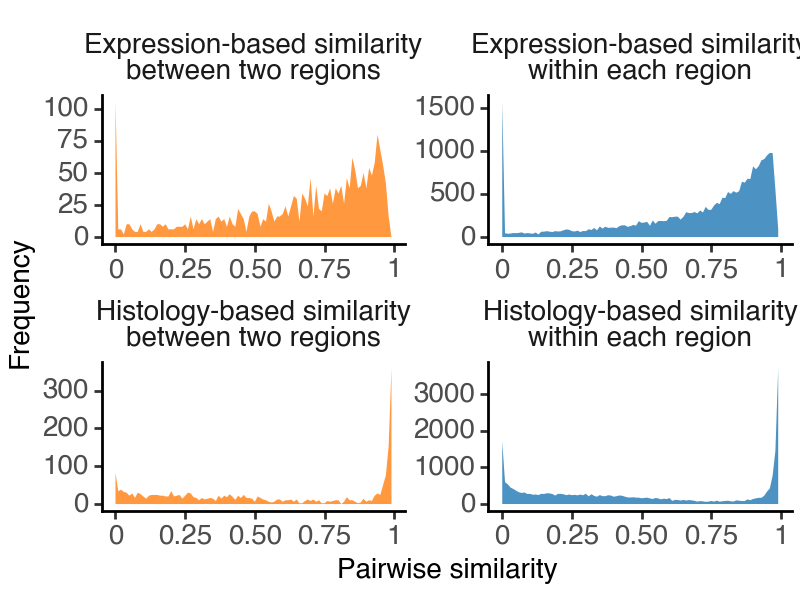

<Figure Size: (400 x 300)>

In [19]:
p = (
    ggplot(
        df_sim, 
        aes(x='x', fill='pair')
    ) + 
        facet_wrap('~source+pair', scales='free', ncol=2) + 
        geom_ribbon(aes(ymax='y_sim', ymin=0), alpha = 0.8) +
        labs(x='Pairwise similarity', y='Frequency', fill='') +
        #scale_y_log10() + 
        scale_fill_manual(values={
            'between two regions': '#ff7f0e', 'within each region': '#1f77b4'
        }) +
        theme_classic() + 
        theme(figure_size=(4,3),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='none')
)
p.save(fig_res_dir + '/fig2e.pdf')
p

## Inspecting pairwise correlation

In [20]:
def _calc_corr(w: SpatialWeightMatrix):
    cov = torch.cholesky_inverse(
        torch.linalg.cholesky(
            w.get_inv_cov(
                'icar', rho=0.99, cached=False, return_sparse=False)
        )
    )
    var = torch.diagonal(cov)
    inv_sd = torch.diagflat(var ** -0.5)
    corr = inv_sd @ cov @ inv_sd
    return corr

In [21]:
def get_stats_swm(swm, is_in_same_group, is_boundary, is_interior):
    # calculate pairwise correlation
    corr = _calc_corr(swm)

    # calculate pdf
    NUM_BIN = 100
    hist_x = np.arange(NUM_BIN)/100
    hist_w_b = torch.histc(
        swm.swm.values()[~is_in_same_group], bins = NUM_BIN, min = 0, max = 1
    ) 
    hist_w_i = torch.histc(
        swm.swm.values()[is_in_same_group], bins = NUM_BIN, min = 0, max = 1
    ) 
    hist_corr_b = torch.histc(
        corr.masked_select(is_boundary.bool().to_dense()), 
        bins = NUM_BIN, min = 0, max = 1
    )
    hist_corr_i = torch.histc(
        corr.masked_select(is_interior.bool().to_dense()), 
        bins = NUM_BIN, min = 0, max = 1
    )

    df = pd.DataFrame({
        'x': np.tile(hist_x, 2),
        'y_weight': torch.concat([hist_w_b, hist_w_i]),
        'y_corr': torch.concat([hist_corr_b, hist_corr_i]),
        'pair': np.repeat(['Between two regions', 'Within each region'], NUM_BIN)
    })
    
    return df

### Hard-scaling by pathology annotation

#### Calculate stats

In [22]:
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)

# calculate weight matrix
w_raw = SpatialWeightMatrix()
w_raw.calc_weights_knn(pixels, k=6)

# scale by annotation
w_hc = SpatialWeightMatrix()
w_hc.calc_weights_knn(pixels, k=6)
w_hc.scale_by_identity(adata.obs['Classification'].to_numpy(), boundary_connectivity=0)

w_hc_l = SpatialWeightMatrix()
w_hc_l.calc_weights_knn(pixels, k=6)
w_hc_l.scale_by_identity(adata.obs['Classification'].to_numpy(), boundary_connectivity=0.01)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.89.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.


In [23]:
df_raw = get_stats_swm(w_raw, is_in_same_group, is_boundary, is_interior)
df_hc = get_stats_swm(w_hc, is_in_same_group, is_boundary, is_interior)
df_hc_l = get_stats_swm(w_hc_l, is_in_same_group, is_boundary, is_interior)
df = pd.concat([df_raw, df_hc, df_hc_l])
df['is_scaled'] = pd.Categorical(
    np.repeat(['Raw', 'Hard pruning', 'Hard pruning (leak=0.01)'], df_raw.shape[0]),
    categories=['Raw', 'Hard pruning', 'Hard pruning (leak=0.01)'], ordered=True
)

#### Visualization

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 2 in image.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/jysumac/Projects/Smoother_paper/results/figures/loss_design/fig2b1.pdf
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10


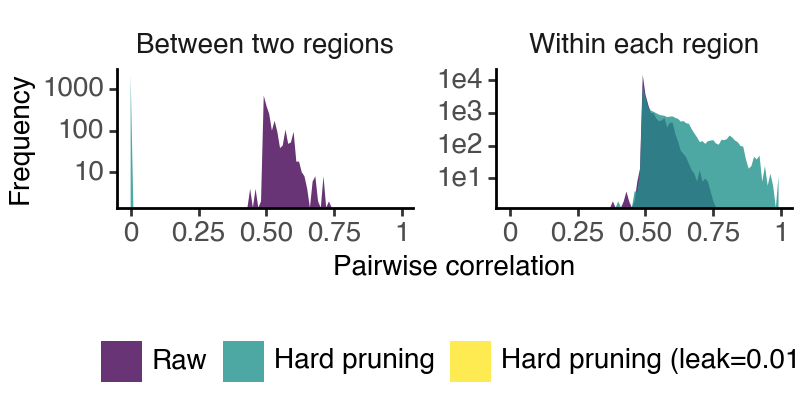

<Figure Size: (400 x 200)>

In [24]:
p = (
    ggplot(
        df[df['is_scaled'].isin(['Raw', 'Hard pruning'])], 
        aes(x='x', group='is_scaled', fill='is_scaled')
    ) + 
        facet_wrap('~pair', scales='free') + 
        geom_ribbon(aes(ymax='y_corr', ymin=0), alpha = 0.8) +
        labs(x='Pairwise correlation', y='Frequency', fill='') +
        scale_y_log10() + 
        theme_classic() + 
        theme(figure_size=(4,2),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='bottom')
)
p.save(fig_res_dir + 'fig2b1.pdf')
p

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 1.5 in image.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/jysumac/Projects/Smoother_paper/results/figures/loss_design/fig2b2.pdf
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10


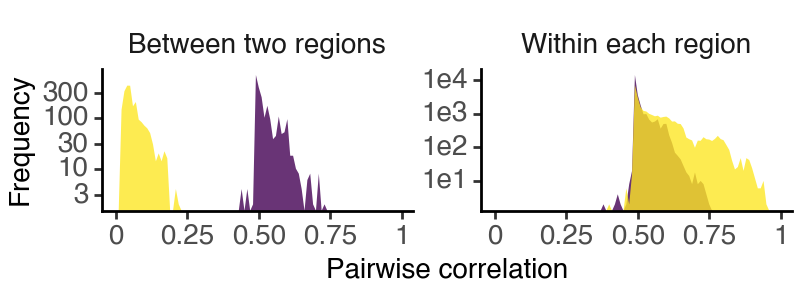

<Figure Size: (400 x 150)>

In [25]:
p = (
    ggplot(
        df[df['is_scaled'].isin(['Raw', 'Hard pruning (leak=0.01)'])], 
        aes(x='x', group='is_scaled', fill='is_scaled')
    ) + 
        facet_wrap('~pair', scales='free') + 
        geom_ribbon(aes(ymax='y_corr', ymin=0), alpha = 0.8) +
        labs(x='Pairwise correlation', y='Frequency', fill='') +
        scale_y_log10() + 
        theme_classic() + 
        theme(figure_size=(4,1.5),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='none')
)
p.save(fig_res_dir + 'fig2b2.pdf')
p

### Soft-scaling using features

#### Calculate statistics

In [26]:
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']
pixels = adata.obsm['spatial']

# calculate weight matrix
w_raw = SpatialWeightMatrix()
w_raw.calc_weights_knn(pixels, k=6)

# soft scale by expression
w_exp = SpatialWeightMatrix()
w_exp.calc_weights_knn(pixels, k=6)
w_exp.scale_by_expr(yy)

w_hist = SpatialWeightMatrix()
w_hist.calc_weights_knn(pixels, k=6)
w_hist.scale_by_histology(pixels, img, sf)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.89.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.


In [27]:
df_raw = get_stats_swm(w_raw, is_in_same_group, is_boundary, is_interior)
df_exp = get_stats_swm(w_exp, is_in_same_group, is_boundary, is_interior)
df_hist = get_stats_swm(w_hist, is_in_same_group, is_boundary, is_interior)
df = pd.concat([df_raw, df_hist, df_raw, df_exp])
df['is_scaled'] = pd.Categorical(
    np.repeat(['Raw', 'Soft (histology)', 'Raw', 'Soft (expression)'], df_raw.shape[0]),
    categories=['Raw', 'Soft (expression)', 'Soft (histology)', 
                'Hard (expression)', 'Hard (histology)'], ordered=True
)
df['source'] = np.repeat(['(Histology-based)', '(Expression-based)'], df_raw.shape[0]*2)

#### Visualize

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.8 x 3 in image.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/jysumac/Projects/Smoother_paper/results/figures/loss_design/fig2f1.pdf
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10


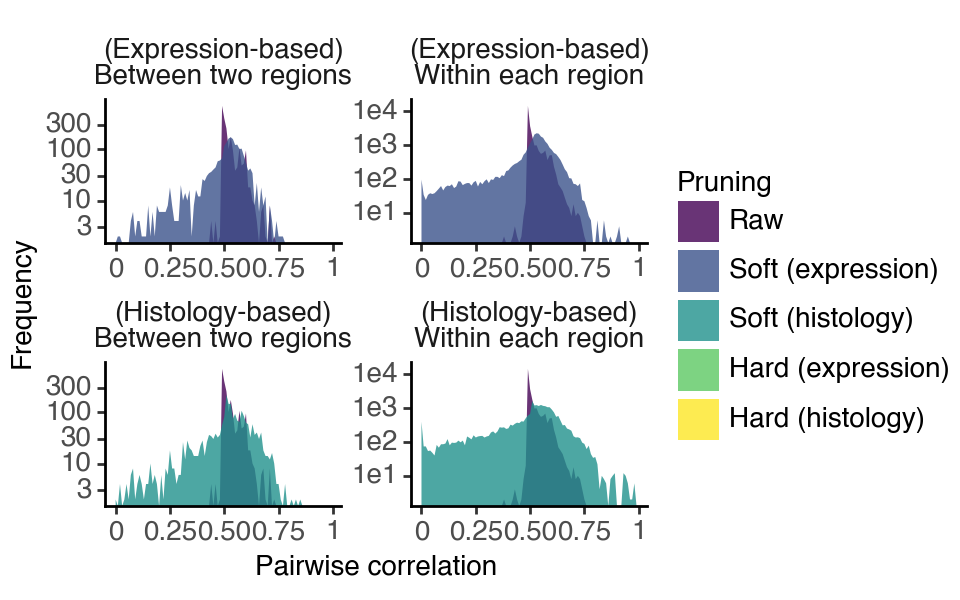

<Figure Size: (480 x 300)>

In [28]:
p = (
    ggplot(
        df, 
        aes(x='x', group='is_scaled', fill='is_scaled')
    ) + 
        facet_wrap('~source+pair', scales='free') + 
        geom_ribbon(aes(ymax='y_corr', ymin=0), alpha = 0.8) +
        labs(x='Pairwise correlation', y='Frequency', fill='Pruning') +
        scale_y_log10() + 
        theme_classic() + 
        theme(figure_size=(4.8,3),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='right')
)
p.save(fig_res_dir + 'fig2f1.pdf')
p

### Hard-scaling using clusters

#### Calculate statistics

In [29]:
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']
pixels = adata.obsm['spatial']

# calculate weight matrix
w_raw = SpatialWeightMatrix()
w_raw.calc_weights_knn(pixels, k=6)

# soft scale by expression
w_exp = SpatialWeightMatrix()
w_exp.calc_weights_knn(pixels, k=6)
w_exp.scale_by_identity(adata.obs['exp_clu_leiden'].to_numpy())

w_hist = SpatialWeightMatrix()
w_hist.calc_weights_knn(pixels, k=6)
w_hist.scale_by_identity(adata2.obs['hist_clu_leiden'].to_numpy())

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.90.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.


In [30]:
df_raw = get_stats_swm(w_raw, is_in_same_group, is_boundary, is_interior)
df_exp = get_stats_swm(w_exp, is_in_same_group, is_boundary, is_interior)
df_hist = get_stats_swm(w_hist, is_in_same_group, is_boundary, is_interior)
df = pd.concat([df_raw, df_hist, df_raw, df_exp])
df['is_scaled'] = pd.Categorical(
    np.repeat(['Raw', 'Hard (histology)', 'Raw', 'Hard (expression)'], df_raw.shape[0]),
    categories=['Raw', 'Soft (expression)', 'Soft (histology)', 
                    'Hard (expression)', 'Hard (histology)'], ordered=True
)
df['source'] = np.repeat(['(Histology-based)', '(Expression-based)'], df_raw.shape[0]*2)

#### Visualize

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.8 x 3 in image.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/jysumac/Projects/Smoother_paper/results/figures/loss_design/fig2f2.pdf
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10


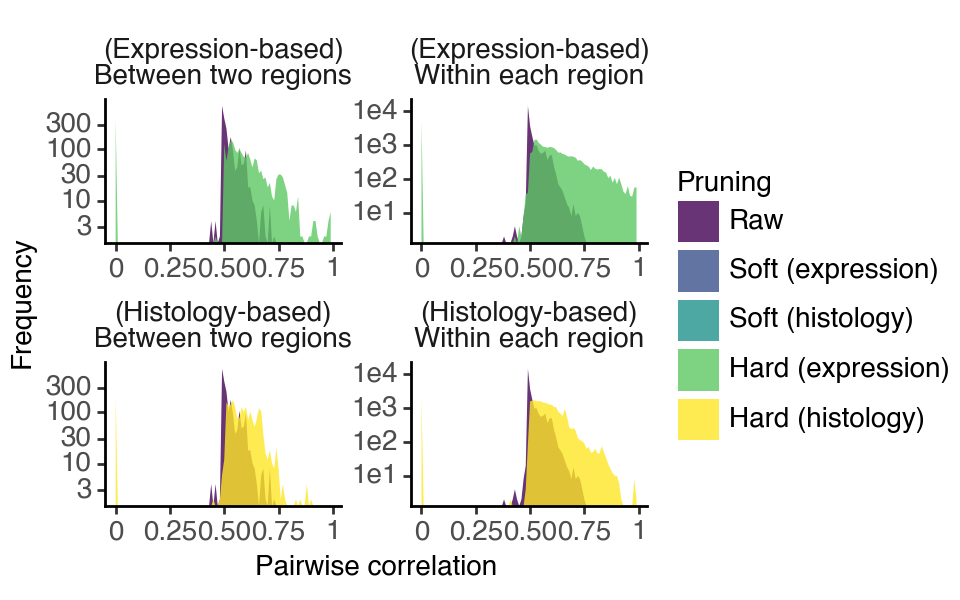

<Figure Size: (480 x 300)>

In [31]:
p = (
    ggplot(
        df, 
        aes(x='x', group='is_scaled', fill='is_scaled')
    ) + 
        facet_wrap('~source+pair', scales='free') + 
        geom_ribbon(aes(ymax='y_corr', ymin=0), alpha = 0.8) +
        labs(x='Pairwise correlation', y='Frequency', fill='Pruning') +
        scale_y_log10() + 
        theme_classic() + 
        theme(figure_size=(4.8,3),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='right')
)
p.save(fig_res_dir + 'fig2f2.pdf')
p

## Detailed comparison of hyperparameters

### Cosine distance vs Euclidean

#### Expression

In [32]:
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)

# calculate transcriptomic similarity
sim_expr_c = calc_feature_similarity_sparse(
    yy, neighbors, nonneg = True,
    dist_metric='cosine', reduce = 'pca', dim = 10, return_type='sparse'
)

# calculate transcriptomic similarity
sim_expr_e = calc_feature_similarity_sparse(
    yy, neighbors, nonneg = True,
    dist_metric='euclidean', reduce = 'pca', dim = 10, return_type='sparse'
)

In [33]:
df_exp_c = get_hist_sim(sim_expr_c, is_in_same_group)
df_exp_e = get_hist_sim(sim_expr_e, is_in_same_group)
df_sim = pd.concat([df_exp_c, df_exp_e])
df_sim['dist'] = np.repeat(['Cosine-based similarity', 'Euclidean-based similarity'], df_exp_c.shape[0])

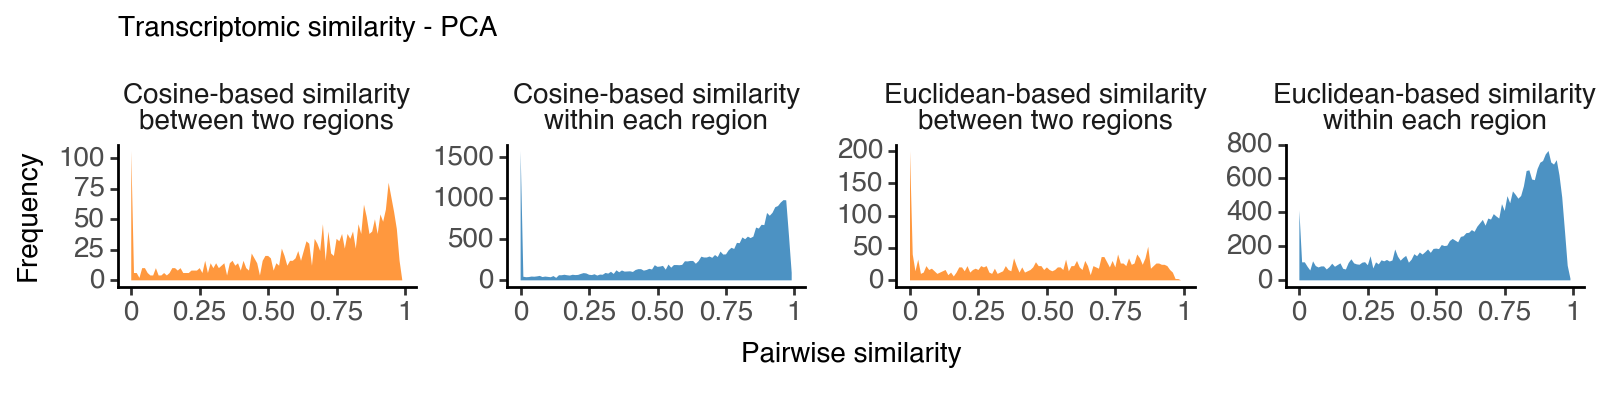

<Figure Size: (800 x 200)>

In [34]:
(
    ggplot(
        df_sim, 
        aes(x='x', fill='pair')
    ) + 
        facet_wrap('~dist+pair', scales='free', ncol=4) + 
        geom_ribbon(aes(ymax='y_sim', ymin=0), alpha = 0.8) +
        labs(x='Pairwise similarity', y='Frequency', fill='', title = 'Transcriptomic similarity - PCA') +
        #scale_y_log10() + 
        scale_fill_manual(values={
            'between two regions': '#ff7f0e', 'within each region': '#1f77b4'
        }) +
        theme_classic() + 
        theme(figure_size=(8,2),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='none')
)

#### Histology - PCA

In [35]:
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']

# spatial coordinates
pixels = adata.obsm['spatial']

# calculate histology similarity
sim_hist_e = calc_histology_similarity_sparse(
    pixels, w_raw.swm.indices(),
    img, scale_factors=sf, 
    dist_metric='euclidean',
    reduce = 'pca',
    dim = 10
)
sim_hist_c = calc_histology_similarity_sparse(
    pixels, w_raw.swm.indices(),
    img, scale_factors=sf, 
    dist_metric='cosine',
    reduce = 'pca',
    dim = 10
)

In [36]:
df_hist_c = get_hist_sim(sim_hist_c, is_in_same_group)
df_hist_e = get_hist_sim(sim_hist_e, is_in_same_group)
df_sim = pd.concat([df_hist_c, df_hist_e])
df_sim['dist'] = np.repeat(['Cosine-based similarity', 'Euclidean-based similarity'], df_hist_c.shape[0])

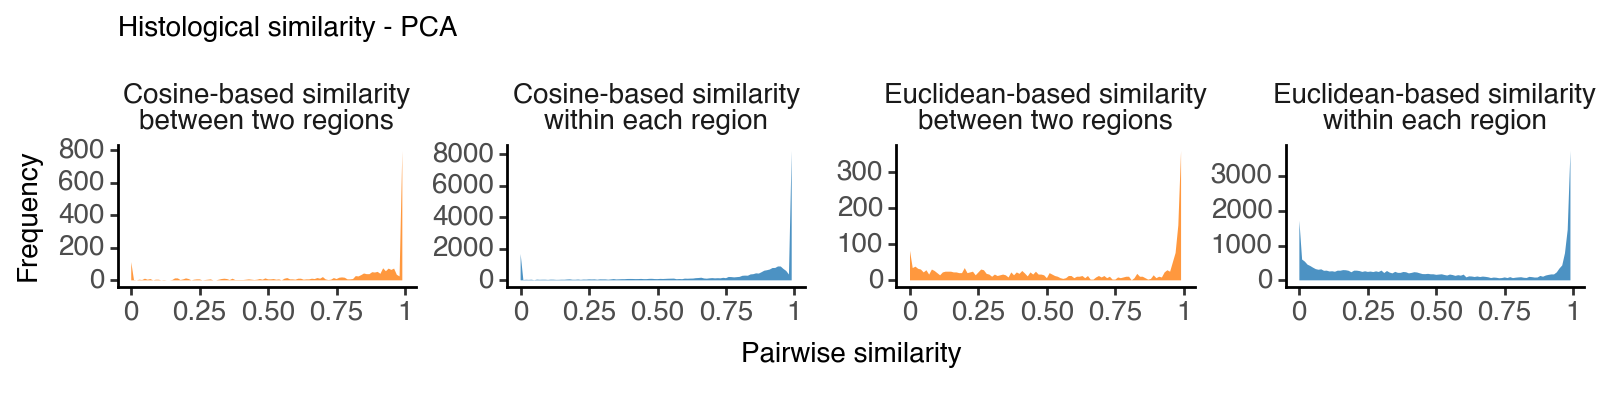

<Figure Size: (800 x 200)>

In [37]:
(
    ggplot(
        df_sim, 
        aes(x='x', fill='pair')
    ) + 
        facet_wrap('~dist+pair', scales='free', ncol=4) + 
        geom_ribbon(aes(ymax='y_sim', ymin=0), alpha = 0.8) +
        labs(x='Pairwise similarity', y='Frequency', fill='', title = 'Histological similarity - PCA') +
        #scale_y_log10() + 
        scale_fill_manual(values={
            'between two regions': '#ff7f0e', 'within each region': '#1f77b4'
        }) +
        theme_classic() + 
        theme(figure_size=(8,2),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='none')
)

#### Histology - Mean

In [38]:
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']

# spatial coordinates
pixels = adata.obsm['spatial']

# calculate histology similarity
sim_hist_e = calc_histology_similarity_sparse(
    pixels, w_raw.swm.indices(),
    img, scale_factors=sf, 
    dist_metric='euclidean',
    reduce = 'mean',
    dim = 10
)
sim_hist_c = calc_histology_similarity_sparse(
    pixels, w_raw.swm.indices(),
    img, scale_factors=sf, 
    dist_metric='cosine',
    reduce = 'mean',
    dim = 10
)

In [39]:
df_hist_c = get_hist_sim(sim_hist_c, is_in_same_group)
df_hist_e = get_hist_sim(sim_hist_e, is_in_same_group)
df_sim = pd.concat([df_hist_c, df_hist_e])
df_sim['dist'] = np.repeat(['Cosine-based similarity', 'Euclidean-based similarity'], df_hist_c.shape[0])

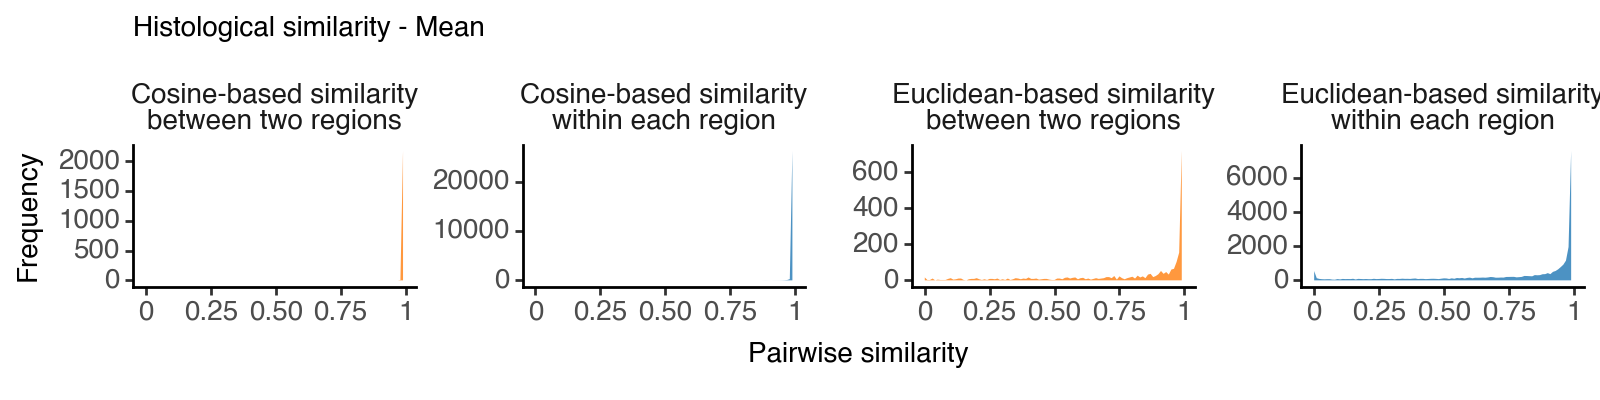

<Figure Size: (800 x 200)>

In [40]:
(
    ggplot(
        df_sim, 
        aes(x='x', fill='pair')
    ) + 
        facet_wrap('~dist+pair', scales='free', ncol=4) + 
        geom_ribbon(aes(ymax='y_sim', ymin=0), alpha = 0.8) +
        labs(x='Pairwise similarity', y='Frequency', fill='', title = 'Histological similarity - Mean') +
        #scale_y_log10() + 
        scale_fill_manual(values={
            'between two regions': '#ff7f0e', 'within each region': '#1f77b4'
        }) +
        theme_classic() + 
        theme(figure_size=(8,2),
             text=element_text(size=10),
             strip_background=element_blank(),
             legend_position='none')
)

## Figures

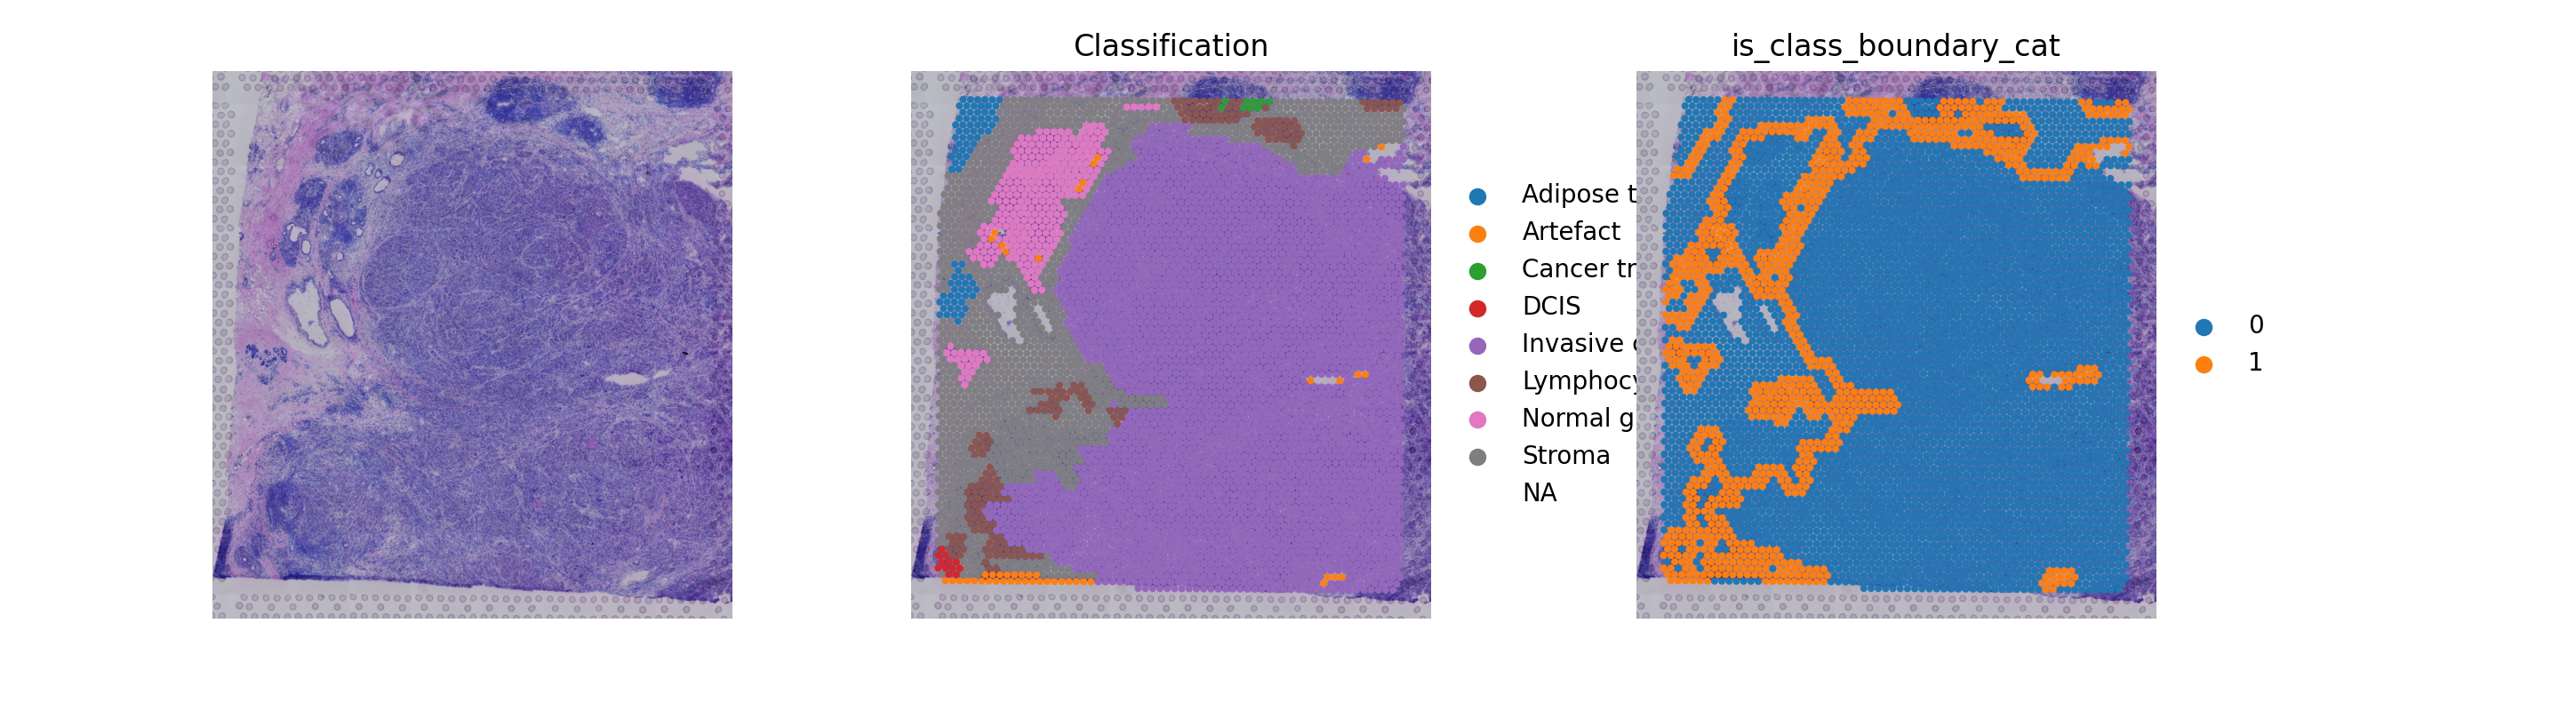

In [41]:
adata.obs['is_class_boundary_cat'] = pd.Categorical(adata.obs['is_class_boundary'])
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.spatial(
        adata, color = [None, 'Classification', 'is_class_boundary_cat'], 
        frameon=False,
        size=1.5, show=False)

plt.savefig(fig_res_dir + '/fig2c1.pdf')
plt.show()

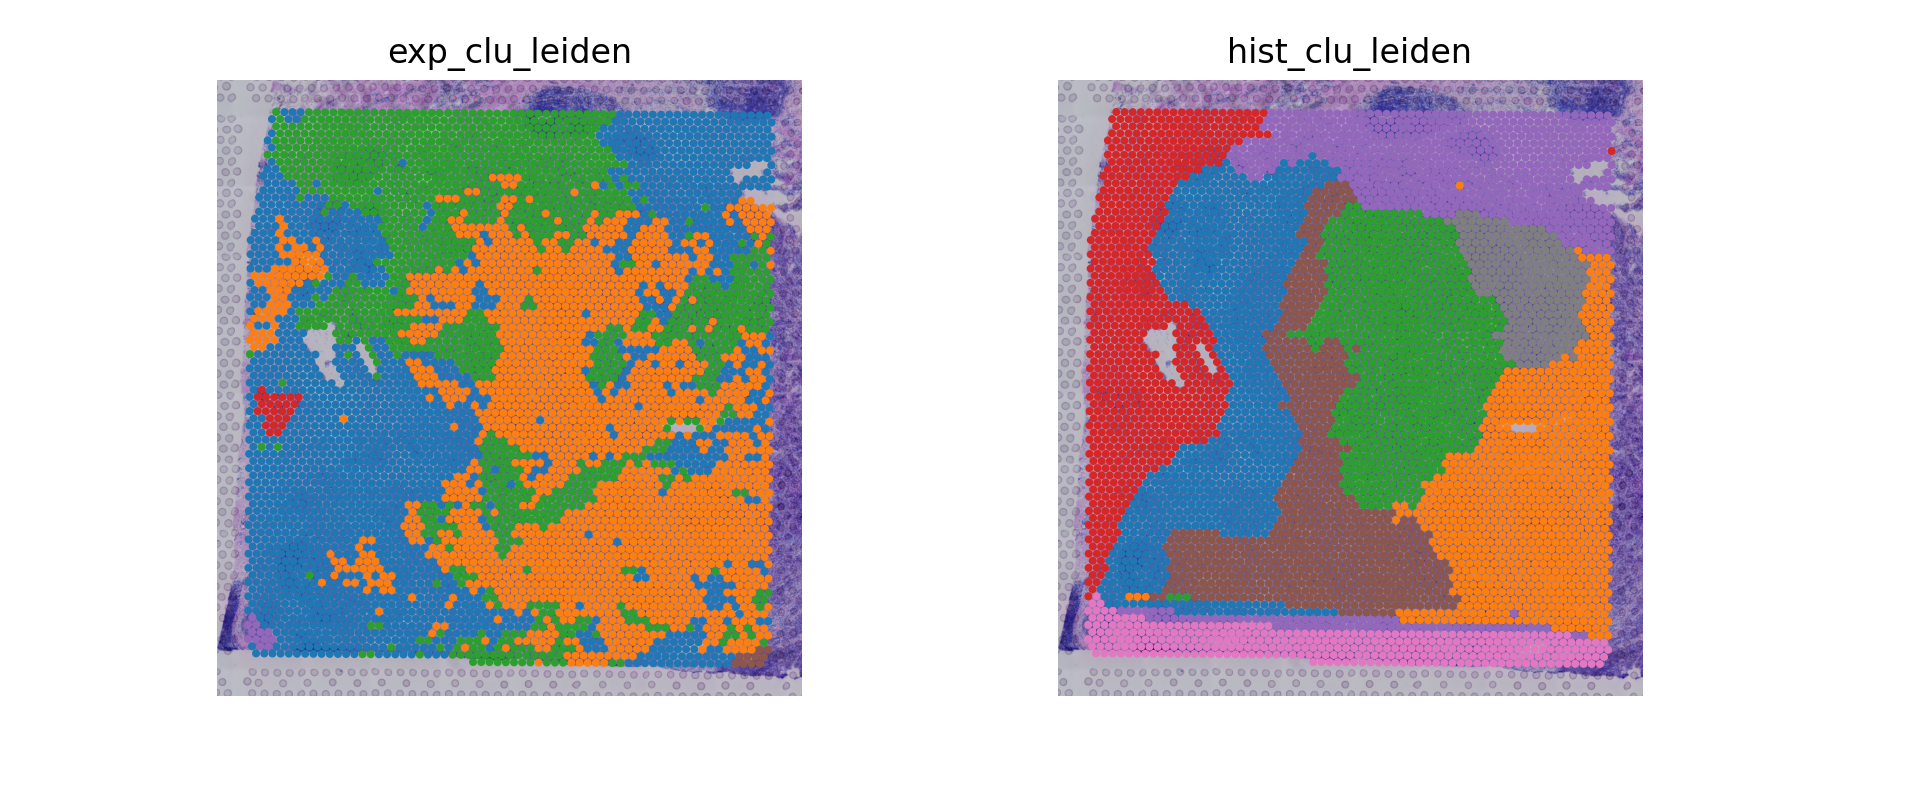

In [42]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.spatial(
        adata2, color = ['exp_clu_leiden', 'hist_clu_leiden'], 
        frameon=False, legend_loc='none',
        size=1.5, show=False)

plt.savefig(fig_res_dir + '/fig2d.pdf')
plt.show()